#Assignment

I had lots of errors when trying to load my keras model on local notebooks when saving from colab. For this reason I have two models one saved locally and the other saved in colab (they perform differently). I have run all evaluation using colab models in colab so please use this aswell. There is a local model available but it does not produce the same results as it was trained seperately.

I have attached my conda environment file in folder if you wanted to try run it locally and were having issues with version. I do not reccomend this.

In [1]:
import tensorflow as tf
import keras
from keras.datasets import mnist
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pickle

# If opening in colab set this to true and change the path in the cell below otherwise ignore
usingColab = True

modelName = "localBest"

# If set to true models will train on training data
trainModels = False

# If set to true the respective model will run
# Testing will run if train models is set to false but run model is set to true
runSVM = True
runKNN = True
runDNN = True
runCNN = True

In [2]:
if usingColab:
  modelName = "best"
  from google.colab import drive
  drive.mount('/content/drive')
  # IMPORTANT - Please change this path to point to the folder of my assignment which you downloaded
  # E.g: /content/drive/MyDrive/pathtoassignment/Assignment
  # It is important there is no '/' at the end of the path so the models can load correctly
  %cd /content/drive/MyDrive/Msc Artificial Intelligence/Semester 1/Machine Learning and Computer Vision/Assginment

Mounted at /content/drive
/content/drive/MyDrive/Msc Artificial Intelligence/Semester 1/Machine Learning and Computer Vision/Assginment


##Load MNIST Dataset

I used the keras library to import the dataset as it comes in a ready to train format with train and test data split for you.

I have displayed the first 20 training examples with their titles as their labels to show what the dataset looks like.

I have made a flattened version of the dataset to use with models that can only train with 1 dimentional data like linear neural networks and support vector machines.

In [3]:
# Load the mnist dataset from keras
(xTrain, yTrain), (xTest, yTest) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
# Reformats the dataset to work with all models
xTrainFlat = [np.reshape(array, (28 * 28)) for array in xTrain]
xTestFlat = [np.reshape(array, (28 * 28)) for array in xTest]

xTrain = [np.reshape(array, (28, 28)) for array in xTrain]
xTest = [np.reshape(array, (28, 28)) for array in xTest]
yTrain = np.reshape(yTrain, (60000, 1))
yTest = np.reshape(yTest, (10000, 1))

# This is for indexing the false positive images
yTestReshaped = yTest.reshape(10000)

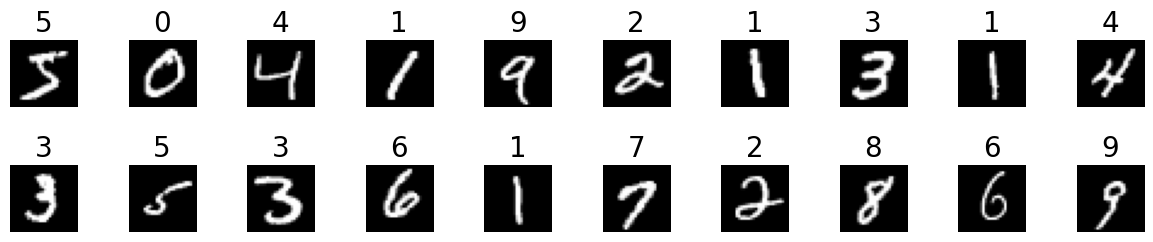

In [5]:
# Displays first 20 training images as well as their labels
fig, axes = plt.subplots(2, 10, figsize=(12, 12))

fig.tight_layout()
plt.subplots_adjust(bottom=0.1, top=0.3)

for i, axs in enumerate(axes):
  for j, ax in enumerate(axs):
    ax.imshow(xTrain[(i*10)+j], 'gray')
    ax.set_title(yTrain[(i*10)+j][0], fontsize=20)
    ax.axis('off')

##Support Vector Machine

A brief explanation of svm's is that they plot lines within the dataset's vector space. The lines are then adjusted using gradient descent to try and maximise a margin width while keeping the accuracy of the desicion boundaries high. This allows the model to avoid outliers/noise in the dataset as the margin moves past them while retaining an accurate decision boundary.

I chose to use a support vector machine for one of the models as it is easy to setup and use and works well for classification tasks. I used the LinearSVC model specifically as it's training time scales well with large data. Other models scale quadratically leading to long training times with less accuracy.



In [6]:
if runSVM and trainModels:
  from sklearn.svm import LinearSVC

  # Trains a linear svm model on the flattened training data

  svmClassifier = LinearSVC(max_iter=1000)
  svmClassifier.fit(xTrainFlat, yTrain)

  # Evaluates the models accuracy on the test data

  svmResult = svmClassifier.predict(xTestFlat)

  correct = 0

  for i in range(len(svmResult)):
    if(svmResult[i] == yTest[i]):
      correct += 1

  print(f"Accuracy is {(correct / len(svmResult)) * 100}%")

  # with open(f"./Models/SVM/{t}.pkl", "wb") as f:
  #   pickle.dump(svmClassifier, f)

### SVM Max Iterations Testing

I tested the model using different values for the max iterations parameter. This was changed as sklearn prompts more iterations when the model doesn't converge. The values below show the accuracy for each max_iter input value. Increasing the iterations did not seem to yield better accuracy with it fluctuating around 85% - 89% for all test cases. The higher the iterations the longer the training time so I decided to stick with the default 1000 iterations as it took around 10 minutes to train compared to the 30 minutes that 5000 iterations takes.

The accuracy had a sparse spread even for the same amount of iterations. I chose to run the 1000 iterations 5 times and use the model with the highest accuracy. The accuracy ranged from 78% - 88%. I saved the 88% model to use.

250  = 85.78%

500  = 84.21%

1000 = 86.45%

1500 = 86.99%

3000 = 83.0%

5000 = 83.0%

7500 = 85.56%


### SVM Confusion Matrix

The confusion matrix below shows the svm performed pooly on specific numbers. The highest rate of false postives was predicting a 4 as a 9. This is unexpected as these numbers don't share many properties. One being all straight lines the other being all curved lines. This might be due to their white pizel layout being similar therefore placing them closer in the vector space.

Another false positive statistics to point out is the model preditcting 8's as 5's. This could be due to the similar curves in the bottom of a 5 and the bottom of an 8.

The model predicted 0's, 1's and 6's well with a false positive total of 54, 16 and 61 respectively. However, it performed worse on the other numbers with all others scoring a false positive total greater than 100 with 8's at the highest with 195 false positive results. This highlights the models flaws in classifying a wide range of handwritten numbers. Some of the highest false positive scores were with numbers with curves possibly showing that the model's vector space did distinguish curves well.

Total false positive for numbers 0 - 9: [ 54  16 121 185 104 115  61 125 195 136]


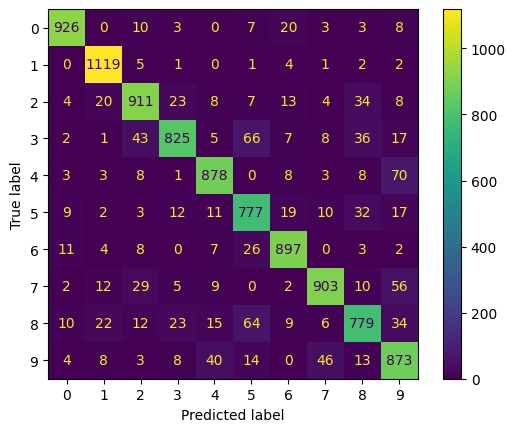

In [7]:
# Loads the best svm model and runs it on the test data to produce the data for the confusion matrix
with open(f"./Models/SVM/1.pkl", "rb") as f:
  bestSVMClassifier = pickle.load(f)

svmResult = bestSVMClassifier.predict(xTestFlat)

# Loads and displays the confusion matrix
SVMConf = confusion_matrix(yTest, svmResult)
print(f"Total false positive for numbers 0 - 9: {np.where(SVMConf < 200, SVMConf, 0).sum(axis=1)}")

conf = ConfusionMatrixDisplay(SVMConf)
conf.plot()
display()

The 2 plots below show the a selection of the misclassified for 8's and 3's (the two highest false positive values). As we can see some are mishaped or their lines are imcomplete. This could lead to it being misplaced in the vector space that the svm uses and being slightly closer to other catergories such as 4 or 5 than 8 or 3.

However, we can see a clear weakness in this model as some of the numbers below are still clearly 3's or 8's despite certain lines being morphed.

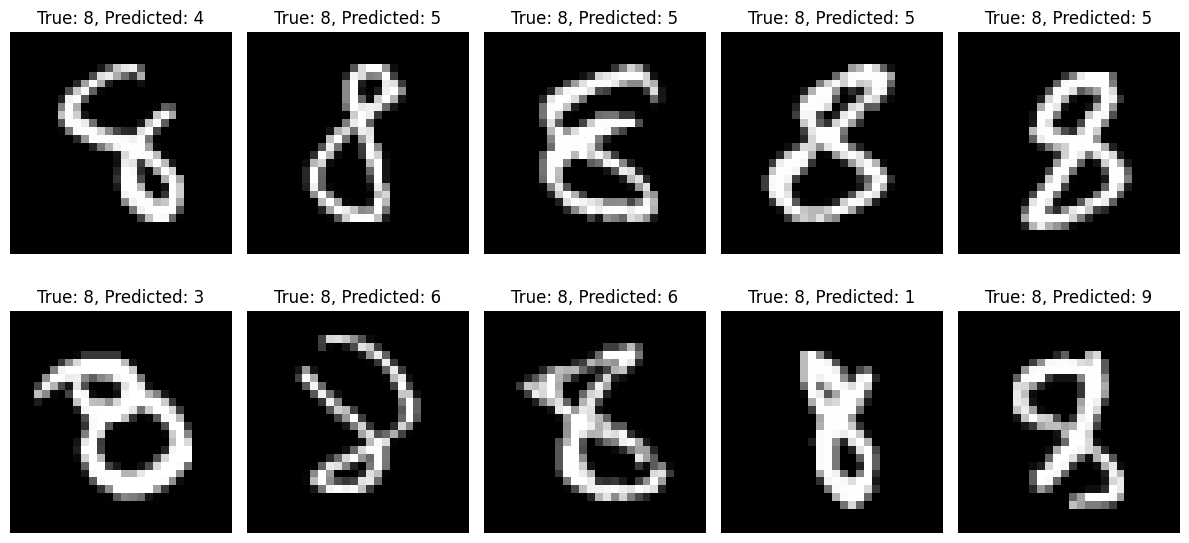

In [8]:
# Shows the false positive images with the true label 8

misclassifiedIndex = np.where((svmResult != yTestReshaped) & (yTestReshaped == 8))[0]

plt.figure(figsize=(12, 6))
for i, idx in enumerate(misclassifiedIndex[20:30]):
  plt.subplot(2, 5, i + 1)
  plt.imshow(xTestFlat[idx].reshape(28, 28), cmap='gray')
  plt.title(f'True: {yTestReshaped[idx]}, Predicted: {svmResult[idx]}')
  plt.axis('off')

plt.tight_layout()
plt.show()

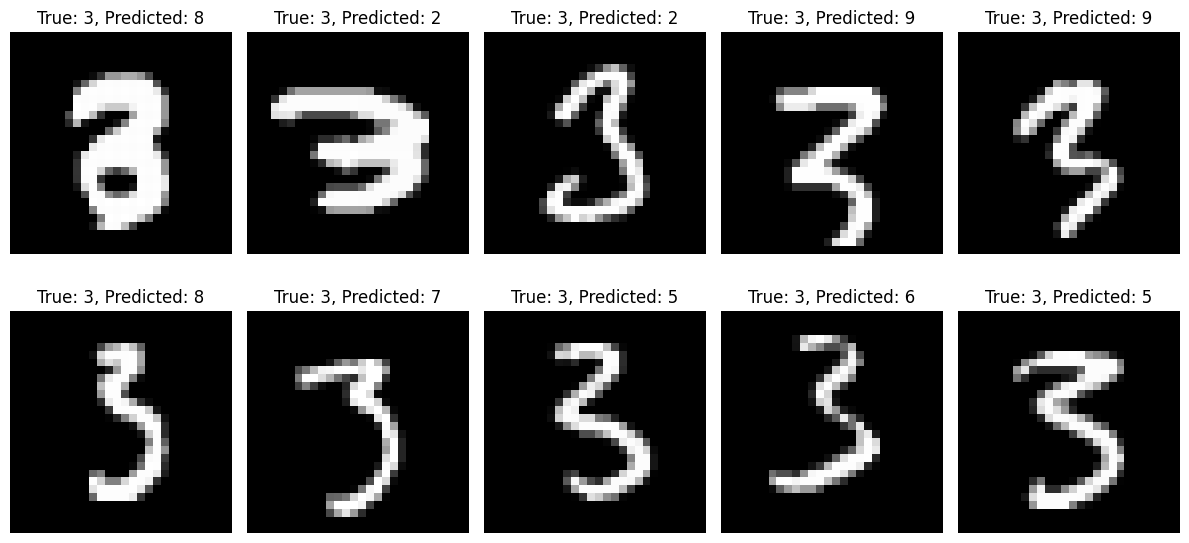

In [9]:
# Shows the false positive images with the true label 3

misclassifiedIndex = np.where((svmResult != yTestReshaped) & (yTestReshaped == 3))[0]

plt.figure(figsize=(12, 6))
for i, idx in enumerate(misclassifiedIndex[20:30]):
  plt.subplot(2, 5, i + 1)
  plt.imshow(xTestFlat[idx].reshape(28, 28), cmap='gray')
  plt.title(f'True: {yTestReshaped[idx]}, Predicted: {svmResult[idx]}')
  plt.axis('off')

plt.tight_layout()
plt.show()

##K-Nearest Neighbours

A brief explanation of KNN is that it uses a value K to determine the label of each dataset. Take a datapoint. If K is 3 the labels for the 3 closest datapoints are tallied up and the label with the highest total gets assigned to this datapoint. This is done for each data point in the whole dataset to train the model. New test data is run through the same procedure (but not saved to the model's vector space) to get its label.

I chose to try and use the KNN algorithm for this task as it works well with clearly distinct classificiation tasks in which mnist is. Some numbers in mnist are simimlar to other but most will fall into a distinct catergory which allows the KNN algorithm to cluster them effectively. KNN is extremely quick only having to run through the training data to train.

I ran the KNN with different K values (1 - 15) and found that 3 worked best with accuracy of 97.05% a significant improvement from the support vector machine.


In [10]:
if runKNN and trainModels:
  from sklearn.neighbors import KNeighborsClassifier

  # Train knn classifier using training datset

  knnClassifier = KNeighborsClassifier(n_neighbors=3)

  knnClassifier.fit(xTrainFlat, yTrain)

  # Evaluate knn accuracy on test dataset

  knnResult = knnClassifier.predict(xTestFlat)
  correct = 0

  for i in range(len(knnResult)):
    if(knnResult[i] == yTest[i]):
      correct += 1

  print(f"Accuracy is {(correct / len(knnResult))*100}%")

  # with open(f"./Models/KNN/n.pkl", "wb") as f:
  #   pickle.dump(knnClassifier, f)

### KNN Confusion Matrix

The KNN confusion matrix shows a better performance than the SVM. It's false positive rate in an individual catergory peaks at 21 for determining 7's as 1's. This false positive is expected as these two numbers look similar and will therefore appear close together in vector space.

The same spread of total false positive can be seen in this matrix when compared to the SVM matrix (just on a smaller scale as the KNN is more accurate). 0's, 1's and 6's have a much smaller false positive rate (6, 2, 14) than the other numbers which are all above 30 peaking at 60 for 8's. This model shows the same weaknesses as SVM on a smaller scale leading it to be much more accurate.

Total false positive for numbers 0 - 9: [ 6  2 36 34 32 33 14 37 60 41]


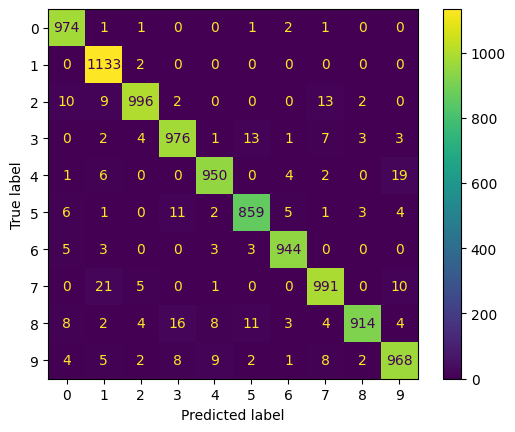

In [11]:
# Load best KNN model to predict test dataset
with open(f"./Models/KNN/n3.pkl", "rb") as f:
  bestKNNClassifier = pickle.load(f)

knnResult = bestKNNClassifier.predict(xTestFlat)

# Use results to plot confusion matrix
KNNConf = confusion_matrix(yTest, knnResult)
print(f"Total false positive for numbers 0 - 9: {np.where(KNNConf < 200, KNNConf, 0).sum(axis=1)}")

conf = ConfusionMatrixDisplay(KNNConf)
conf.plot()
display()

The 2 plots below show a selection of the false positive results from the 8's and 9's catergories. These were chosen as they have the highest total false positive rate.

As you can see some of the results are deformed compared to a perfect version of their respective number. This shows that the KNN cannot deal with small deformations in the numbers lines, scale and rotation. It still has similar weaknesses when compared to the SVM as it still can't recognise numbers without big deformations. I think this is because of the sensative boundaries that KNN forms. It usually overfits to data and therefore cannot deal with small deformations in the data.

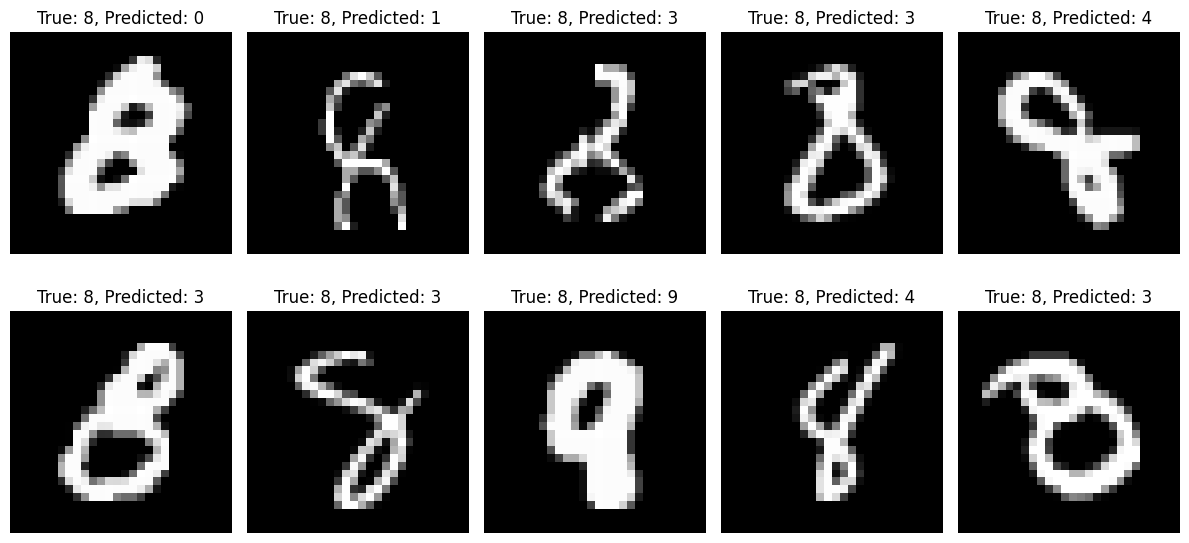

In [12]:
# Shows the false positive images with the true label 8

misclassifiedIndex = np.where((knnResult != yTestReshaped) & (yTestReshaped == 8))[0]

plt.figure(figsize=(12, 6))
for i, idx in enumerate(misclassifiedIndex[:10]):
  plt.subplot(2, 5, i + 1)
  plt.imshow(xTestFlat[idx].reshape(28, 28), cmap='gray')
  plt.title(f'True: {yTestReshaped[idx]}, Predicted: {knnResult[idx]}')
  plt.axis('off')

plt.tight_layout()
plt.show()

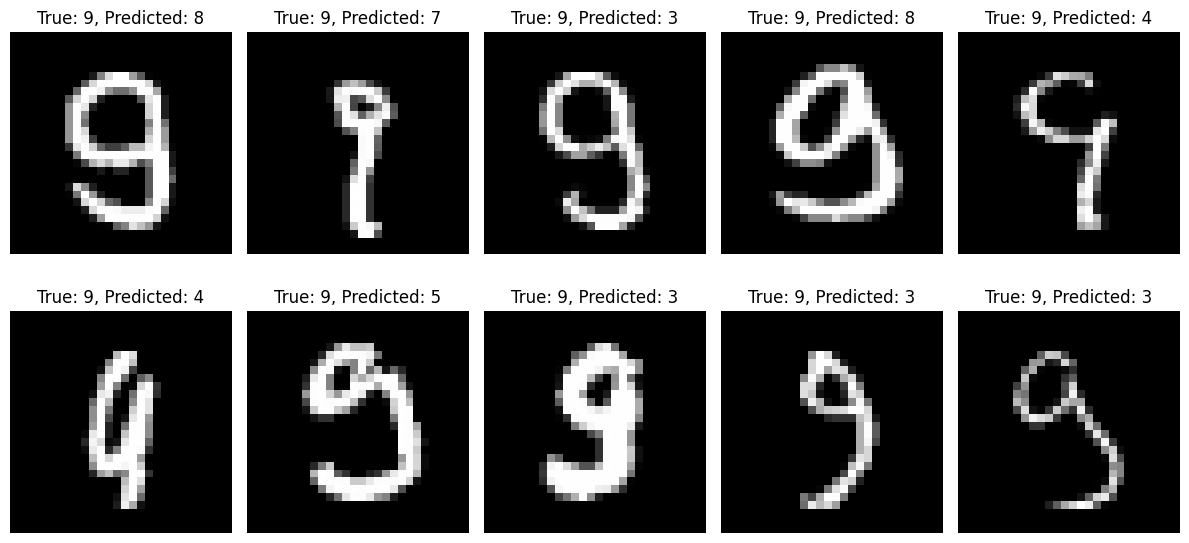

In [13]:
# Shows the false positive images with the true label 9

misclassifiedIndex = np.where((knnResult != yTestReshaped) & (yTestReshaped == 9))[0]

plt.figure(figsize=(12, 6))
for i, idx in enumerate(misclassifiedIndex[:10]):
  plt.subplot(2, 5, i + 1)
  plt.imshow(xTestFlat[idx].reshape(28, 28), cmap='gray')
  plt.title(f'True: {yTestReshaped[idx]}, Predicted: {knnResult[idx]}')
  plt.axis('off')

plt.tight_layout()
plt.show()

##Deep Neural Network

I also attempted to use a standard DNN to classify the mnist dataset. This was because of the power of generalisation. Neural networks (if trained correctly) have the ability to generalise to new un-seen test data. This is useful for this task as people have different handwriting styles and being able to generalise for many different styles is important and needed.

I tested different hyperparameters to test if they would increase performance. As there are so many hyperparameters for deep neural network models I decided to keep some constant to reduce the amount of testing needed. I set the learning rate, epochs, loss function, activation function and optimizer as default or the same only changing the amount of layers, the layer size and the batch size. I chose relu as the activation function as it seemed the best fit. Sigmoid doesn't work well with data that isn't normalized.

I found through testing that batch size did not affect accuracy much so stuck with 256 to stay on the lower end as the paper below concludes that lower batch sizes lead to better results in training.

I found that a model starting with a layer with a relatively large size of 128 then tapering off with two more layers with a size of 32 and 16 worked best. It lead to less overfitting unlike bigger models and still offered 94% accuracy.

Masters, D. and Luschi, C. (2018). REVISITING SMALL BATCH TRAINING FOR DEEP NEURAL NETWORKS. [online] Available at: https://arxiv.org/pdf/1804.07612.pdf.

In [14]:
if runDNN and trainModels:

  # Build DNN model structure
  inputs = keras.Input(shape=(np.shape(xTrainFlat[0])))
  x = keras.layers.Dense(128, activation=tf.nn.relu)(inputs)
  x = keras.layers.Dense(32, activation=tf.nn.relu)(x)
  x = keras.layers.Dense(16, activation=tf.nn.relu)(x)
  outputs = keras.layers.Dense(10, activation=tf.nn.softmax)(x)

  model = keras.Model(inputs=inputs, outputs=outputs)

  # Compile model with the adam optimiser and cross entropy loss function
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

  model.summary()

In [15]:
if runDNN and trainModels:

  # Train DNN using training data for 50 epochs with a batch of 256

  yTrainKeras = np.array(yTrain)
  xTrainKeras = np.array(xTrainFlat)

  print("------------------------------------------ Training ------------------------------------------")

  model.fit(x=xTrainKeras, y=yTrainKeras, batch_size=256, epochs=50)

In [16]:
if runDNN:
  print("------------------------------------------ Testing ------------------------------------------")

  with open(f"./Models/DNN/{modelName}.pkl", "rb") as f:
    model = pickle.load(f)

  # Predicting the test data using the DNN

  xTestKeras = np.array(xTestFlat)

  results = model.predict(xTestKeras)

  # Evaluate the accuracy of the model on the test dataset

  dnnResult = np.argmax(results, axis=1)

  correct = 0
  for yHat, y in zip(dnnResult, yTest):
    if yHat == y:
      correct += 1

  print(f"Accuracy is {(correct / len(dnnResult))*100}%")

  # with open("./Models/DNN/{modelName}.pkl", "wb") as f:
  #   pickle.dump(model, f)

------------------------------------------ Testing ------------------------------------------
313/313 [==============================] - 1s 2ms/step
Accuracy is 94.0%


### Batch Size Testing with TensorBoard

In [17]:
# Loading the tensorboard extension to record model performance
# %load_ext tensorboard
# import tensorflow as tf

In [18]:
# Runs 4 models with different batch sizes and records their test data performance each epoch

# batchSizes = [64, 128, 256, 512]

# for size in batchSizes:
#   model = keras.Model(inputs=inputs, outputs=outputs)

#   model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

#   yTrainKeras = np.array(yTrain)
#   xTrainKeras = np.array(xTrainFlat)

#   print("------------------------------------------ Training ------------------------------------------")

  # Only run the commented code below if you want to see it in tensorboard live
  # Should produce the same results as the png below this code

  #logdir = f"./logs/modelSmallBatchSize{size}"
  #tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir)

  #model.fit(x=xTrainKeras, y=yTrainKeras, batch_size=size, epochs=50, validation_data=(xTestKeras, yTestKeras), callbacks=[tensorboard_callback])

![Batch Size Results](https://drive.google.com/uc?export=view&id=1H4s3Dapbgeh3xbhi06uKIwlM_UAiUzRV)

The results above show little effect of batch sizing on the accuracy.

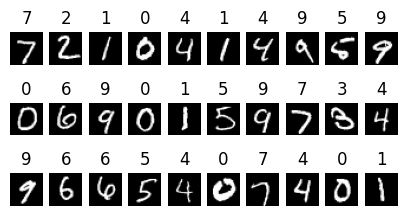

In [19]:
# Results of the model

if runDNN:
  fig, axes = plt.subplots(3, 10, figsize=(5, 5))
  plt.subplots_adjust(bottom=0.1, top=0.5)

  for i, axs in enumerate(axes):
    for j, ax in enumerate(axs):
      ax.imshow(xTest[(i*10)+j], 'gray')
      ax.set_title(dnnResult[(i*10)+j])
      ax.axis('off')

### DNN Confusion Matrix

The DNN confusion matrix shows similar distributions to the other matrices. 0's, 1's and 6's have the least total false positive while the other have considerably higher totals. However, a difference is that 9's have the highest false positive rate differing from 8's like in the other confusion matrices.

The model seems to get confused with 4's, 9's and 7's. 4's get predicted as 9's the most when consifering only false positive results. Same with 7's. This could show the model was overfitting slightly guessing 7's and 4's are 9's alot knowing it will get most right but some wrong.

Overall this confusion matrix highlights the weaknesses in the DNN model when distinguishing between 7's, 4's and 9's as well as showing similar weaknesses to the KNN and SVM model.

313/313 [==============================] - 1s 2ms/step
Total false positive for numbers 0 - 9: [29 22 76 81 59 74 47 71 74 67]


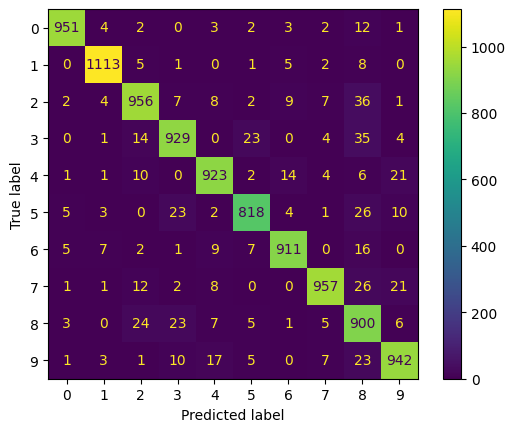

In [20]:
with open(f"./Models/DNN/{modelName}.pkl", "rb") as f:
  bestDNNModel = pickle.load(f)

# Compute predictions on test dataset
dnnResult = bestDNNModel.predict(np.array(xTestFlat))

dnnResult = np.argmax(dnnResult, axis=1)

# Plot confusion matrix for the test dataset
DNNConf = confusion_matrix(yTest, dnnResult)
conf = ConfusionMatrixDisplay(DNNConf)
print(f"Total false positive for numbers 0 - 9: {np.where(DNNConf < 200, DNNConf, 0).sum(axis=1)}")
conf.plot()
display()

The plots below show the first 10 false positive results for the categories 8 and 9.

The plot showing 8's showing a mixture of deformed and normal 8's. This shows that the model struggles with categorising cases with deformaties as well as cases that seem normal. It seems to identify specific features with certain numbers such as straight lines not being associated with 8's. Therefore, when an 8 is drawn with relatively straight lines the model fails.

The 9's plot shows more deformaties than the 8's plot showing a better understanding of the catergory 9 as it only fails on heavily deformed numbers. However, some of these cases are still quite obviously a 9 which shows the model as failed to grasp all the features associated with the number 9. I catergorises alot of 9's as 8's and 4's showing that it has similar features defined for these 3 numbers.

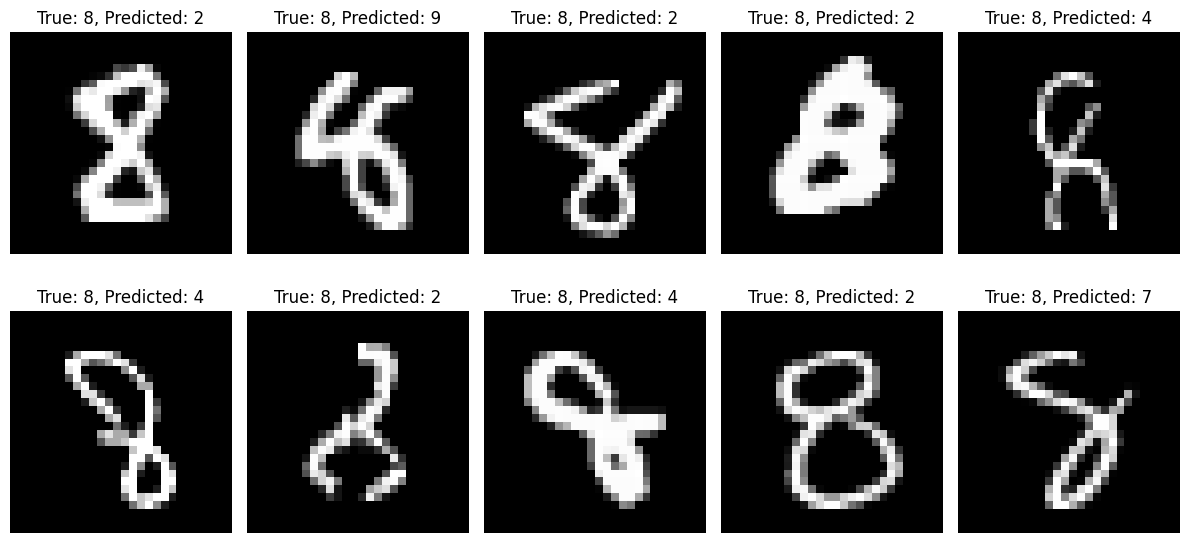

In [21]:
# Shows the false positive images with the true label 8

misclassifiedIndex = np.where((dnnResult != yTestReshaped) & (yTestReshaped == 8))[0]

plt.figure(figsize=(12, 6))
for i, idx in enumerate(misclassifiedIndex[:10]):
  plt.subplot(2, 5, i + 1)
  plt.imshow(xTest[idx], cmap='gray')
  plt.title(f'True: {yTestReshaped[idx]}, Predicted: {dnnResult[idx]}')
  plt.axis('off')

plt.tight_layout()
plt.show()

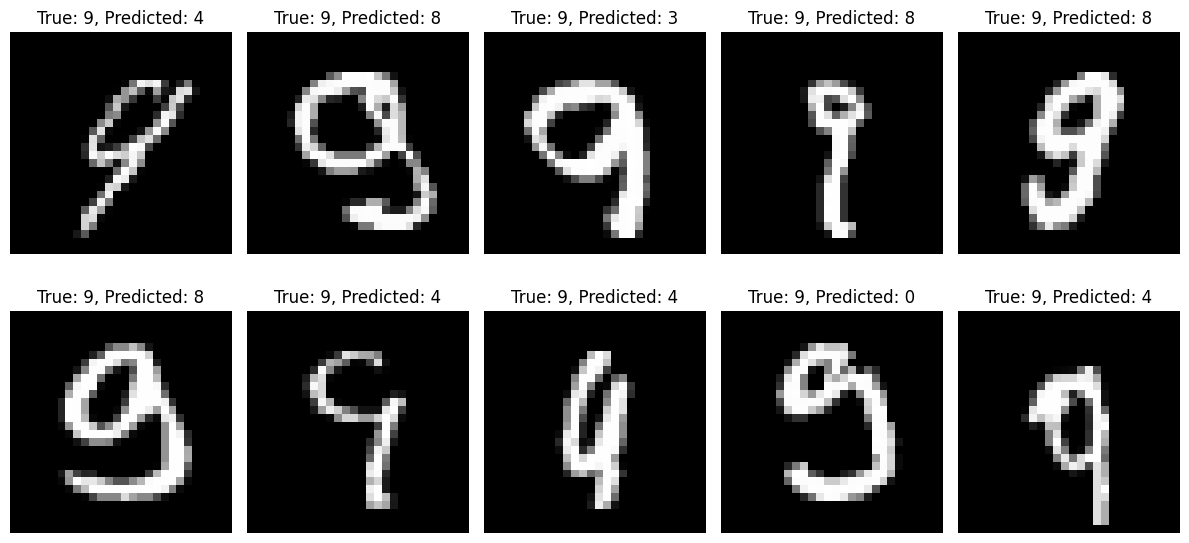

In [22]:
# Shows the false positive images with the true label 9

misclassifiedIndex = np.where((dnnResult != yTestReshaped) & (yTestReshaped == 9))[0]

plt.figure(figsize=(12, 6))
for i, idx in enumerate(misclassifiedIndex[:10]):
  plt.subplot(2, 5, i + 1)
  plt.imshow(xTest[idx], cmap='gray')
  plt.title(f'True: {yTestReshaped[idx]}, Predicted: {dnnResult[idx]}')
  plt.axis('off')

plt.tight_layout()
plt.show()

## Convolutional Neural Network

I also chose to use a CNN for this task. This is because CNN can learn feature maps of images to help with generalisation. If the right feature maps are learnt during training obscure test data can still be identified correctly. This is powerful in real world settings were noise can be present in images.

I decided to use max pooling after my convolution layers as it allows the main features to be preserved while saving on memory and speed.

In [23]:
if runCNN and trainModels:

  # Build CNN model structure
  inputs = keras.Input(shape=(28, 28, 1))
  x = keras.layers.Conv2D(32, 3, activation=tf.nn.relu, padding="same")(inputs)
  x = keras.layers.MaxPooling2D(pool_size=(2, 2), padding="same")(x)
  x = keras.layers.Conv2D(64, 3, activation=tf.nn.relu, padding="same")(x)
  pool = keras.layers.MaxPooling2D(pool_size=(2, 2), padding="same")(x)
  flat = keras.layers.Flatten()(pool)
  full = keras.layers.Dense(256, activation=tf.nn.relu)(flat)
  outputs = keras.layers.Dense(10, activation=tf.nn.softmax)(full)

  model = keras.Model(inputs=inputs, outputs=outputs)

  # Compile CNN model with adam optimizer and cross entropy loss function
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])

  model.summary()

In [24]:
if runCNN and trainModels:

  # Train CNN on training data for 10 epochs with batch size of 256
  model.fit(np.array(xTrain), np.array(yTrain), epochs=10, batch_size=256)

In [25]:
if runCNN:
  print("------------------------------------------ Testing ------------------------------------------")

  # Load best CNN model and predict test dataset
  with open(f"./Models/CNN/{modelName}.pkl", "rb") as f:
    model = pickle.load(f)

  results = model.predict(np.array(xTest))

  # Evaluate accuracy on test dataset
  cnnResult = np.argmax(results, axis=1)

  correct = 0
  for yHat, y in zip(cnnResult, yTest):
    if yHat == y:
      correct += 1

  print(f"Accuracy is {(correct / len(cnnResult))*100}%")

  # with open(f"./Models/CNN/{modelName}.pkl", "wb") as f:
#   pickle.dump(model, f)

------------------------------------------ Testing ------------------------------------------
313/313 [==============================] - 4s 12ms/step
Accuracy is 98.21%


<ipython-input-26-064c0a5c94e6>:5: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


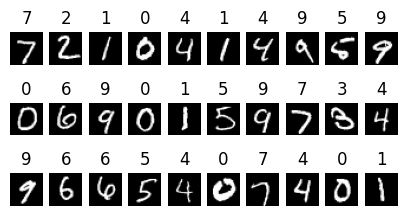

In [26]:
if runCNN:
  # Displays the models labels for the respective image shown from the test dataset
  fig, axes = plt.subplots(3, 10, figsize=(5, 5))

  fig.tight_layout()
  plt.subplots_adjust(bottom=0.1, top=0.5)

  for i, axs in enumerate(axes):
    for j, ax in enumerate(axs):
      ax.imshow(xTest[(i*10)+j], 'gray')
      ax.set_title(cnnResult[(i*10)+j])
      ax.axis('off')

### CNN Confusion Matrix

The confusion matrix for the CNN model shows a high amount of true positive results. The false positive results are also more evenly spread than other model especially when compared to the other high performing model (KNN). It shows that the CNN understands all the catergories at a similar accuracy. This is shown as the KNN has low false positive totals for 0's and 1's while the CNN shares similar results for all numbers except 7's and 8's.

7's are predicted to be 2's and 9's the most when mis-classified. This could be because of deformations within the number 7 which could show it being closer to a number with curves (2 and 9) instead of a number with straight lines like 7's.

8's are predicted most as 9's. This could be because the bottom circle in the 8 is deformed enough to form a solid blob leading the model to believe it is a line with a circle ontop which is closer to a 9.

313/313 [==============================] - 3s 10ms/step
Total false positive for numbers 0 - 9: [10 10 11 16 17 12 15 36 34 18]


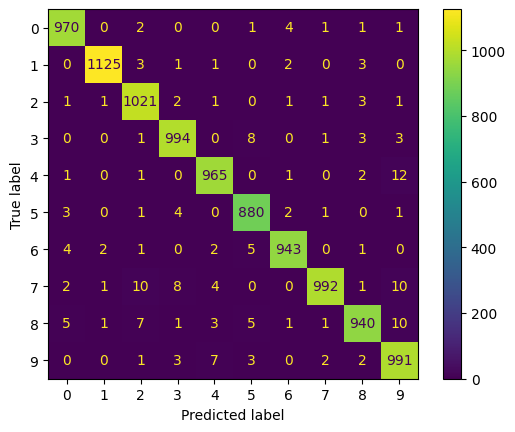

In [27]:
# Loads CNN to predict test dataset for confusion matrix
# Load local if in local env if not load best

# with open(f"./Models/CNN/best.pkl", "rb") as f:
#   bestCNNModel = pickle.load(f)

with open(f"./Models/CNN/{modelName}.pkl", "rb") as f:
  bestCNNModel = pickle.load(f)

results = bestCNNModel.predict(np.array(xTest))

cnnResult = np.argmax(results, axis=1)

# Plots confusion matrix for test dataset
CNNConf = confusion_matrix(yTest, cnnResult)
conf = ConfusionMatrixDisplay(CNNConf)
print(f"Total false positive for numbers 0 - 9: {np.where(CNNConf < 200, CNNConf, 0).sum(axis=1)}")
conf.plot()
display()

We can see a distinct difference between the false positive results for the CNN compared to other models. The CNN seems to be able to generalise to test cases with slight deformations and breaks in lines unlike other models. We can suggest this as the false positive results shown below are heavily deformed or different from most cases.

This can be seen in the 7's plot as they are either deformed in some way or contain a line through the number which is different to other 7 cases where there is no line in the middle. This does show a limitation with the CNN. However, it shows much better generatlisation than other models.

The 8 plot also strengthens the case for the CNN being good at generalising for slight changes as these false positives are heavily deformed.

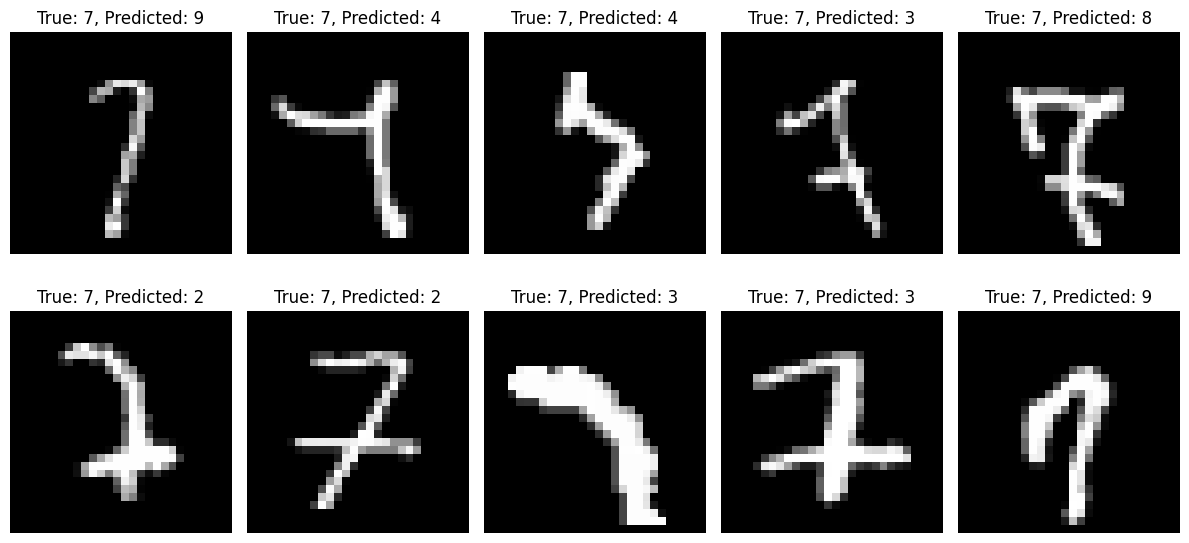

In [28]:
# Shows the false positive images with the true label 7

misclassifiedIndex = np.where((cnnResult != yTestReshaped) & (yTestReshaped == 7))[0]

plt.figure(figsize=(12, 6))
for i, idx in enumerate(misclassifiedIndex[:10]):
  plt.subplot(2, 5, i + 1)
  plt.imshow(xTest[idx], cmap='gray')
  plt.title(f'True: {yTestReshaped[idx]}, Predicted: {cnnResult[idx]}')
  plt.axis('off')

plt.tight_layout()
plt.show()

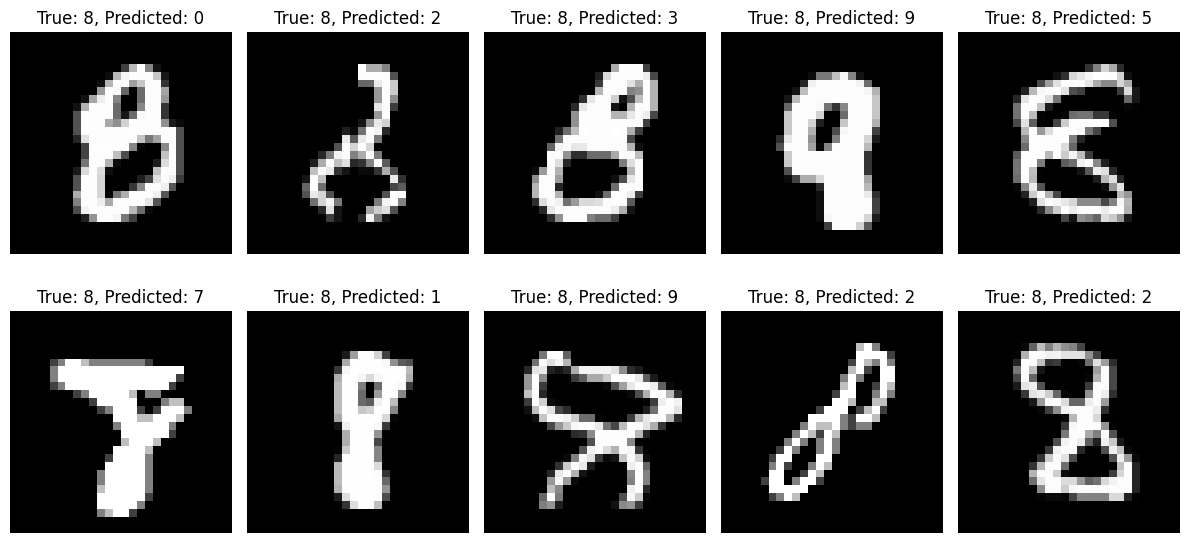

In [29]:
# Shows the false positive images with the true label 8

misclassifiedIndex = np.where((cnnResult != yTestReshaped) & (yTestReshaped == 8))[0]

plt.figure(figsize=(12, 6))
for i, idx in enumerate(misclassifiedIndex[:10]):
  plt.subplot(2, 5, i + 1)
  plt.imshow(xTest[idx], cmap='gray')
  plt.title(f'True: {yTestReshaped[idx]}, Predicted: {cnnResult[idx]}')
  plt.axis('off')

plt.tight_layout()
plt.show()

## Conclusion

In conclusion this notebook shows the differences in performance for 4 machine learning models. The notebook displays potential optimisations for each model's parameters. The results show that SVM's and DNN's do not perform well overall for this dataset. It also shows that DNN's, SVM's and KNN's cannot generalise well to test case's with slight deformations in their structure. The results for CNN show it has the highest accuracy for this dataset and the false positive plots show it generalise well for slight deformations but cannot handle severe deformations.